# Figure 1: The ActiveDROPS platform enables high-throughput characterization of kinesin motor dynamics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az
from scipy.ndimage import gaussian_filter1d


First let's load our data and clean it up

In [2]:
df = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/102224-k401-kif3_titrations-RT/output_data/merged_expression_PIV.csv")

# Assuming df is your DataFrame
# Find rows where the condition contains an underscore
df = df[df['condition'].str.contains('_')]

# Extract motor protein type
df['motor'] = df['condition'].apply(lambda x: x.split('_')[0])

# Extract DNA concentration
df['DNA'] = df['condition'].apply(
    lambda x: float(x.split('-')[0].split('_')[1].replace('nM', '').replace('p', '.'))
)

# Add replicate column with default value 1
df['replicate'] = 1

# Find rows where the condition has a third entry when split by "_"
has_third_entry = df['condition'].apply(lambda x: len(x.split('_')) > 2)

# Parse replicate from third entry when split by "_"
df.loc[has_third_entry, 'replicate'] = df.loc[has_third_entry, 'condition'].apply(
    lambda x: int(x.split('_')[2].replace('-RT', ''))
)

# keep only the replicate 1
df = df[(df['replicate'] == 1) & (df['motor'] == 'K401')]

# drop NaNs
# df = df.dropna()

# rename the column 'protein Concentration_nM' to 'prot'
# df.rename(columns={'Protein Concentration_nM': 'prot'}, inplace=True)
df

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h),motor,DNA,replicate
0,K401_0p625nM-RT,Rep1,0,0.0,0.000000,10.795248,1.376854,30.630794,3.675695e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
1,K401_0p625nM-RT,Rep1,60,1.0,0.016667,10.763086,1.372752,30.539536,3.664744e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
2,K401_0p625nM-RT,Rep1,120,2.0,0.033333,10.526032,1.342518,29.866912,3.584029e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
3,K401_0p625nM-RT,Rep1,180,3.0,0.050000,10.755514,1.371786,30.518051,3.662166e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
4,K401_0p625nM-RT,Rep1,240,4.0,0.066667,10.683785,1.362638,30.314526,3.637743e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23539,K401_160nM-RT,Rep1,156660,2611.0,43.516667,248.420162,31.684158,704.875596,8.458507e+11,-5.395992e+06,...,-59.935861,0.000059,0.001771,1.357683e-21,5.730718e-17,2611.0,43.516667,K401,160.000,1
23540,K401_160nM-RT,Rep1,156720,2612.0,43.533333,248.571295,31.703434,705.304427,8.463653e+11,-4.926835e+06,...,64.889801,0.000059,0.001771,7.267319e-22,5.730791e-17,2612.0,43.533333,K401,160.000,1
23541,K401_160nM-RT,Rep1,156780,2613.0,43.550000,248.410521,31.682928,704.848240,8.458179e+11,3.952846e+06,...,-26.856246,0.000059,0.001771,4.342076e-22,5.730834e-17,2613.0,43.550000,K401,160.000,1
23542,K401_160nM-RT,Rep1,156840,2614.0,43.566667,245.499449,31.311643,696.588268,8.359059e+11,2.643593e+07,...,61.026611,0.000059,0.001771,7.137019e-22,5.730905e-17,2614.0,43.566667,K401,160.000,1


In [3]:
df.columns

Index(['condition', 'subcondition', 'time (s)', 'Time_min', 'Time_h',
       'Mean Intensity', 'Protein Concentration_ng_ul',
       'Protein Concentration_nM', 'Number of Protein Molecules',
       'Rate of Change of Protein Molecules per Second',
       'Translation Rate aa_s', 'Unnamed: 0', 'frame', 'x [m]_mean',
       'y [m]_mean', 'u [m/s]_mean', 'v [m/s]_mean', 'data type [-]_mean',
       'vorticity [1/s]_mean', 'velocity magnitude [m/s]_mean',
       'divergence [1/s]_mean', 'dcev [1]_mean', 'shear [1/s]_mean',
       'strain [1/s]_mean', 'vector direction [degrees]_mean',
       'correlation length [m]_mean', 'distance [m]_mean', 'power [W]_mean',
       'work [J]_mean', 'time (min)', 'time (h)', 'motor', 'DNA', 'replicate'],
      dtype='object')

(A) Schematic representation of the motor protein library construction and
ActiveDROPS experiment setup. Different plasmids encoding various motor proteins
are PCR amplified to obtain linear DNA, which is then combined with microtubules
and a cell-free transcription-translation (TXTL) system. The mixture is placed
in a 96-well plate filled with oil, where the droplets sink to the bottom for
imaging. This format allows for oxygen exchange while preventing desiccation and
enables multiplexed screening of multiple motors simultaneously. (B)
Illustration of the ActiveDROPS mechanism, showcasing the expression of motor
proteins within the droplet, their natural self-dimerization without chemical
crosslinkers, and the harnessing of ATP in the mixture to induce microtubule
dynamics that vary depending on the motor. (C) Time-lapse imaging of an
ActiveDROPS experiment, displaying the microtubule channel, mVenus channel
(motor proteins tagged with mVenus), and a composite view at 0, 6, 12, and 24
hours, highlighting the motor-microtubule activity over time.

For panels D and E let's explore what can we say given the data we have
collected.


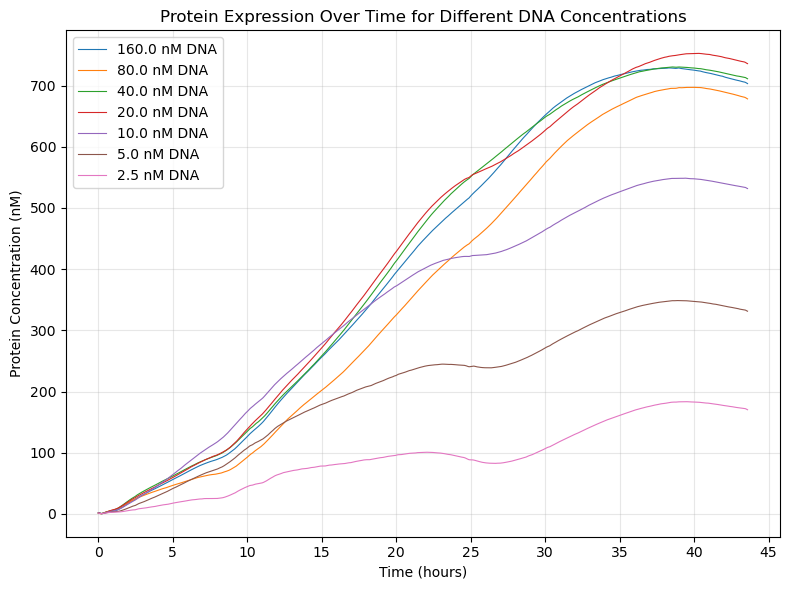

In [4]:
# Create figure
plt.figure(figsize=(8, 6))

# Get unique DNA concentrations in decreasing order
dna_concentrations = sorted(df['DNA'].unique(), reverse=True)[:-2]  # Exclude last two concentrations

# Plot protein concentration over time for each DNA concentration
for dna in dna_concentrations:
    subset = df[df['DNA'] == dna]
    
    # Apply Gaussian smoothing
    protein_conc_smooth = gaussian_filter1d(subset['Protein Concentration_nM'], sigma=4)
    
    plt.plot(subset['Time_h'], protein_conc_smooth, 
             label=f'{dna} nM DNA',
             linewidth=0.8)

plt.xlabel('Time (hours)')
plt.ylabel('Protein Concentration (nM)')
plt.title('Protein Expression Over Time for Different DNA Concentrations')
plt.legend()
plt.grid(True, alpha=0.3)

# Set x-axis ticks every 5 hours
plt.xticks(np.arange(0, df['Time_h'].max() + 5, 5))

plt.tight_layout()
plt.show()


Huh, it's really weird that the decrease in max protein concentration doesn't
correspond to decreasing (halving) the DNA concentration... Could this suggest
that GFP actually matures faster than the motor protein? Because clearly this
relationship exists for power or mean velocity. But wait, that doesn't really
make a lot of sense because there's a 1:1 relationship between the two...

Like for example

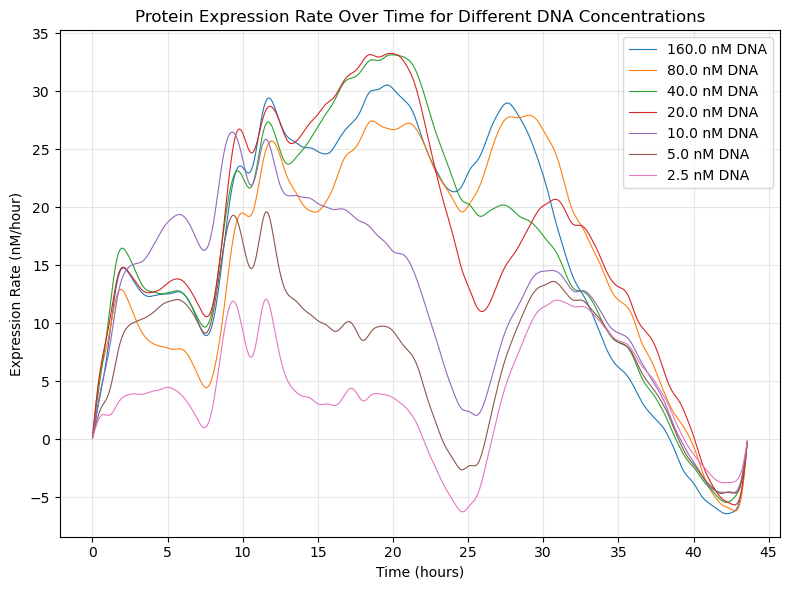

In [5]:
# Create figure
plt.figure(figsize=(8, 6))

# Get unique DNA concentrations in decreasing order
dna_concentrations = sorted(df['DNA'].unique(), reverse=True)[:-2]  # Exclude last two concentrations

# Plot expression rate over time for each DNA concentration
for dna in dna_concentrations:
    subset = df[df['DNA'] == dna]
    
    # Calculate expression rate as change in protein concentration over time
    # First smooth the protein concentration data
    protein_conc_smooth = gaussian_filter1d(subset['Protein Concentration_nM'], sigma=24)
    
    # Calculate rate of change (derivative)
    time_diff = np.diff(subset['Time_h'])
    conc_diff = np.diff(protein_conc_smooth)
    expression_rate = conc_diff / time_diff
    
    # Plot at midpoints of time intervals
    time_midpoints = subset['Time_h'].iloc[:-1] + time_diff/2
    
    plt.plot(time_midpoints, expression_rate,
             label=f'{dna} nM DNA',
             linewidth=0.8)

plt.xlabel('Time (hours)')
plt.ylabel('Expression Rate (nM/hour)')
plt.title('Protein Expression Rate Over Time for Different DNA Concentrations')
plt.legend()
plt.grid(True, alpha=0.3)

# Set x-axis ticks every 5 hours
plt.xticks(np.arange(0, df['Time_h'].max() + 5, 5))

plt.tight_layout()
plt.show()


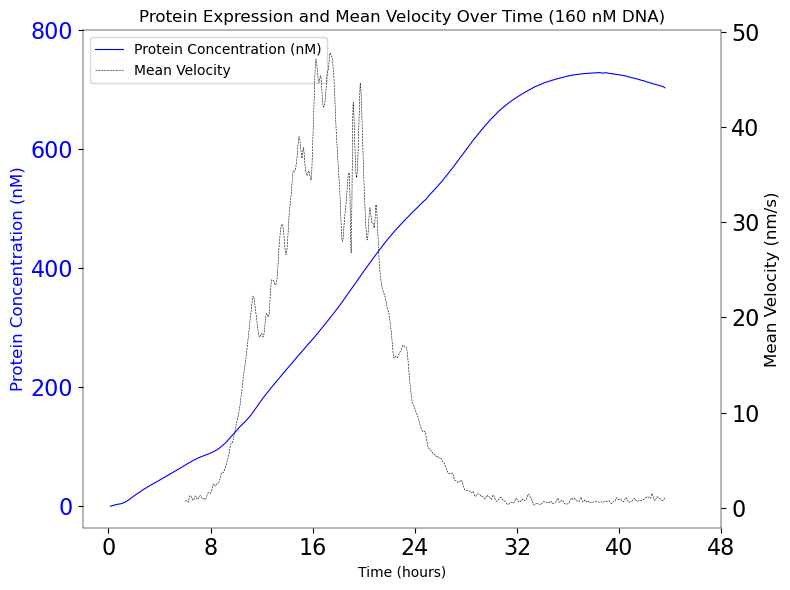

In [6]:
# Create plot with two y-axes
fig, ax1 = plt.subplots(figsize=(8, 6), linewidth=0.5)  # Reduced linewidth from 0.5 to 0.25
ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis

# Get data for 80nM DNA concentration dropping NaNs first
subset_all = df[df['DNA'] == 160].dropna()
subset_velocity = subset_all[subset_all['Time_h'] >= 6]

# Apply Gaussian filter to the data
from scipy.ndimage import gaussian_filter1d
protein_conc_smooth = gaussian_filter1d(subset_all['Protein Concentration_nM'], sigma=4)
# Convert velocity from m/s to nm/s (multiply by 1e9)
velocity_smooth = gaussian_filter1d(subset_velocity['velocity magnitude [m/s]_mean'] * 1e9, sigma=4)

# Plot protein concentration with solid line
line1 = ax1.plot(subset_all['Time_h'], protein_conc_smooth,
         color='blue', linestyle='-',
         linewidth=0.8, label='Protein Concentration (nM)')

# Plot mean velocity with dashed line in black
line2 = ax2.plot(subset_velocity['Time_h'], velocity_smooth,
         color='black', linestyle='--',
         linewidth=0.4, alpha=1, label='Mean Velocity')  # Reduced linewidth from 0.8 to 0.4

# Customize plot
ax1.set_xlabel('Time (hours)', fontsize=10)
ax1.set_ylabel('Protein Concentration (nM)', color='blue', fontsize=12)
ax2.set_ylabel('Mean Velocity (nm/s)', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=16)
ax2.tick_params(axis='y', labelcolor='black', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)

# Set y-axis ticks for protein concentration every 200
max_conc = max(protein_conc_smooth)
ax1.set_yticks(np.arange(0, max_conc + 200, 200))

# Reduce the thickness of the plot's frame for both axes
for spine in ax1.spines.values():
    spine.set_linewidth(0.22)  # Set the desired linewidth for ax1
for spine in ax2.spines.values():
    spine.set_linewidth(0.22)  # Set the desired linewidth for ax2

# Set x-axis ticks every 5 hours
ax1.set_xticks(np.arange(0, max(subset_all['Time_h']) + 8, 8))

ax1.set_title('Protein Expression and Mean Velocity Over Time (160 nM DNA)', fontsize=12)

# Combine legends from both axes into one legend inside the plot
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

# ax1.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig('Fig1_D_overlayed.svg', format='svg', dpi=300)

plt.show()


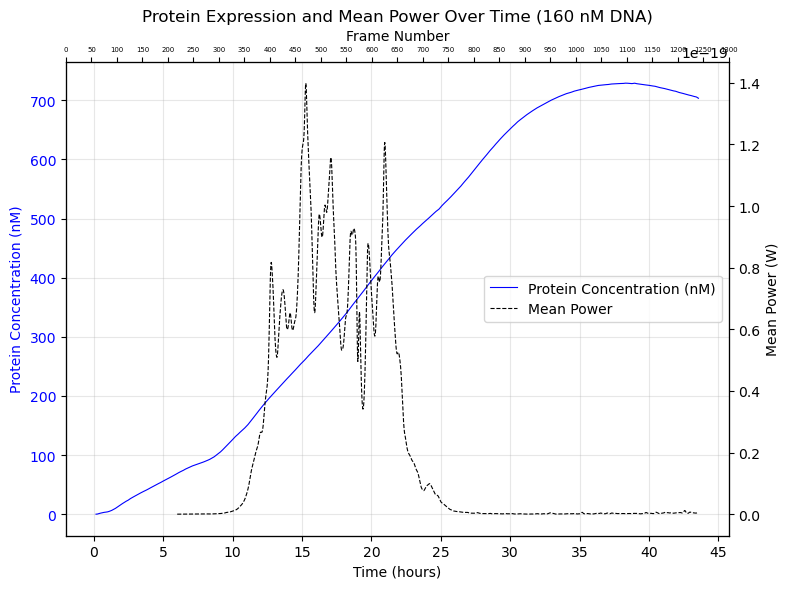

In [7]:
# Create plot with two y-axes
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis

# Get data for 80nM DNA concentration dropping NaNs first
subset_all = df[df['DNA'] == 160].dropna()
subset_velocity = subset_all[subset_all['Time_h'] >= 6]

# Apply Gaussian filter to the data
protein_conc_smooth = gaussian_filter1d(subset_all['Protein Concentration_nM'], sigma=4)
power_smooth = gaussian_filter1d(subset_velocity['power [W]_mean'], sigma=4)

# Plot protein concentration with solid line
line1 = ax1.plot(subset_all['Time_h'], protein_conc_smooth,
         color='blue', linestyle='-',
         linewidth=0.8, label='Protein Concentration (nM)')

# Plot mean power with dashed line in black
line2 = ax2.plot(subset_velocity['Time_h'], power_smooth,
         color='black', linestyle='--',
         linewidth=0.8, alpha=1, label='Mean Power')

# Customize plot
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Protein Concentration (nM)', color='blue')
ax2.set_ylabel('Mean Power (W)', color='black')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis ticks every 5 hours
time_ticks = np.arange(0, max(subset_all['Time_h']) + 5, 5)
ax1.set_xticks(time_ticks)

# Add second x-axis for frame numbers with smaller font
ax3 = ax1.twiny()
frame_ticks = np.arange(0, subset_all['frame'].max(), 100)  # Set frame ticks every 100
ax3.set_xticks(frame_ticks)
ax3.set_xticklabels([f'{int(f/2)}' for f in frame_ticks], fontsize=5)  # Divide frame numbers by 2
ax3.set_xlabel('Frame Number')

ax1.set_title('Protein Expression and Mean Power Over Time (160 nM DNA)')

# Combine legends from both axes into one legend inside the plot
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

ax1.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()


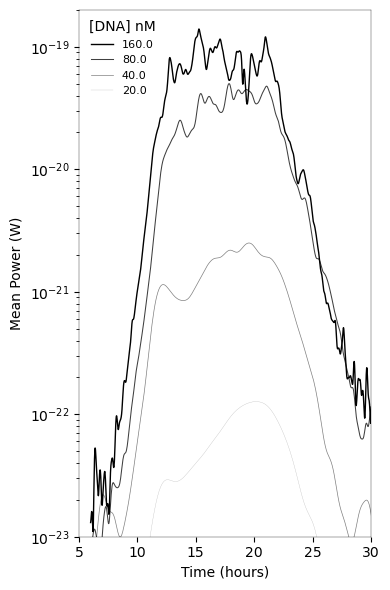

In [8]:
# Create figure and filter data to start at 5h
plt.figure(figsize=(4, 6), linewidth=0.5)  # Reduced frame linewidth

# Get unique DNA concentrations and select 4 largest
dna_concentrations = sorted(df['DNA'].unique(), reverse=True)[:4]

# Plot power vs time for each DNA concentration
for i, dna_conc in enumerate(dna_concentrations):
    if pd.isna(dna_conc):
        continue
        
    # Get data for this DNA concentration
    subset = df[df['DNA'] == dna_conc].dropna()
    subset = subset[subset['Time_h'] >= 6]  # Filter for time >= 6h
    
    # Apply Gaussian smoothing
    power_smooth = gaussian_filter1d(subset['power [W]_mean'], sigma=4)
    
    # Calculate alpha value and linewidth that decrease with DNA concentration
    alpha = 1.0 - (i * 0.25)  # Alpha decreases by 0.25 for each lower concentration
    linewidth = 1 - (i * 0.25)  # Linewidth decreases by 0.3 for each lower concentration
    
    # Plot with label showing DNA concentration, all in black with varying transparency and thickness
    plt.plot(subset['Time_h'], power_smooth, 
             label=f'{dna_conc}',
             color='black',
             alpha=alpha,
             linewidth=linewidth,
             linestyle='-')

plt.xlabel('Time (hours)')
plt.ylabel('Mean Power (W)')
plt.legend(title='[DNA] nM', loc='upper left', frameon=False, prop={'size': 8})

# Set x-axis ticks every 5 hours starting at 5
plt.xticks(np.arange(5, 31, 5))
plt.xlim(5, 30)

# set a y axis limit of 10^-23 to 2x10-19
plt.ylim(10**-23, 2*10**-19)
# set y axis to log scale
plt.yscale('log')

# Reduce frame thickness
plt.gca().spines['top'].set_linewidth(0.25)
plt.gca().spines['right'].set_linewidth(0.25)
plt.gca().spines['bottom'].set_linewidth(0.25)
plt.gca().spines['left'].set_linewidth(0.25)

plt.tight_layout()

# Save as SVG before showing
plt.savefig('Fig1_D_power.svg', format='svg', dpi=300)
plt.show()


/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_30812/844425251.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_data = subset_velocity['power [W]_mean'].fillna(method='ffill').fillna(method='bfill')
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_30812/844425251.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_data = subset_velocity['power [W]_mean'].fillna(method='ffill').fillna(method='bfill')
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_30812/844425251.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_data = subset_velocity['power [W]_mean'].fillna(method='ffill').fillna(method='bfill')
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_30812/84442

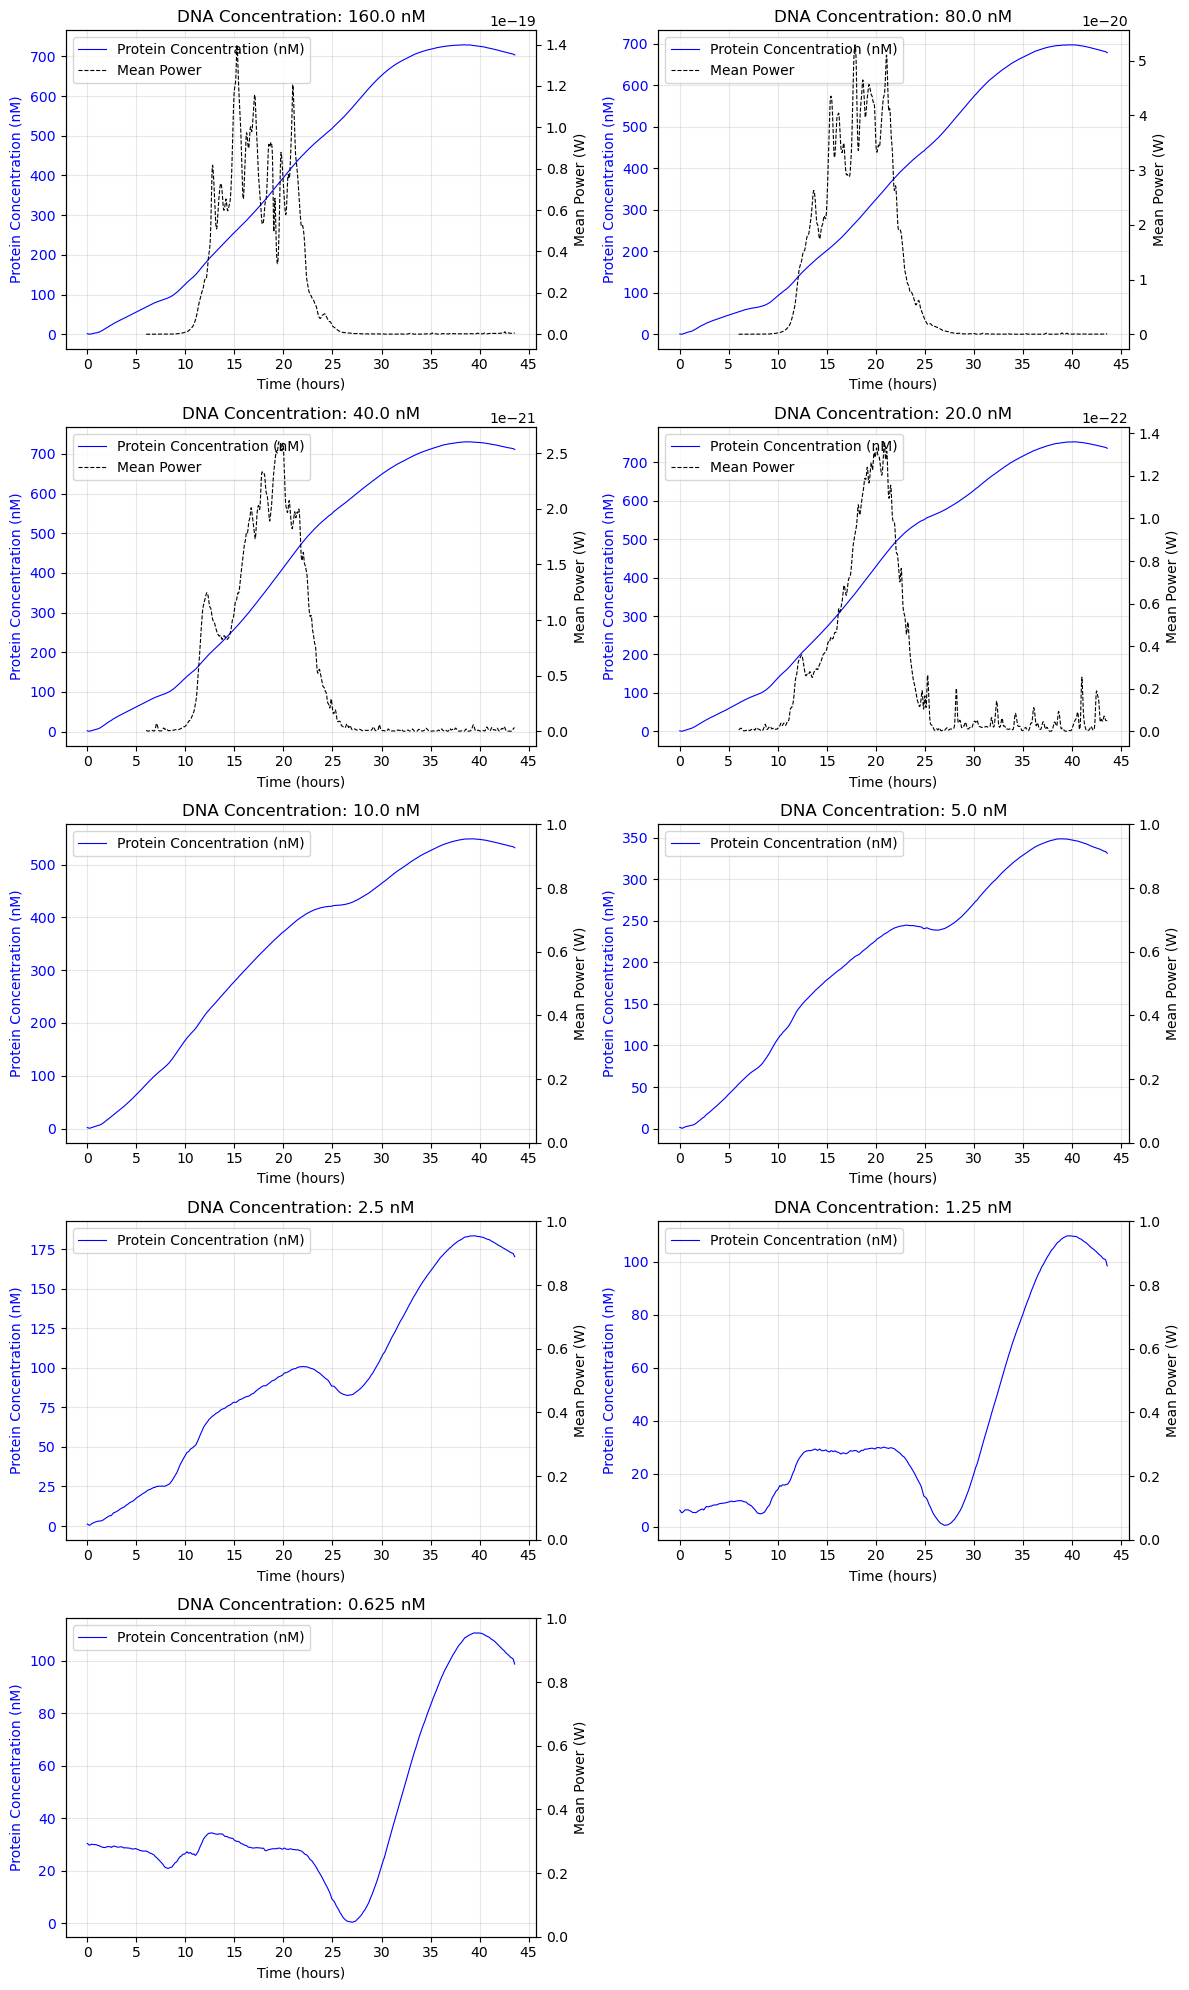

In [9]:
# Get unique DNA concentrations
dna_concentrations = sorted(df['DNA'].unique())

# Calculate number of rows and columns for subplot grid
n_plots = len(dna_concentrations)
n_cols = 2
n_rows = (n_plots + 1) // 2

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
axes = axes.flatten()

# Reverse the order of DNA concentrations to plot 160nM first
dna_concentrations = dna_concentrations[::-1]

for idx, dna_conc in enumerate(dna_concentrations):
    ax1 = axes[idx]
    ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis
    
    # Get data for current DNA concentration dropping NaNs first
    subset_all = df[df['DNA'] == dna_conc].dropna(subset=['Time_h', 'Protein Concentration_nM'])
    subset_velocity = subset_all[subset_all['Time_h'] >= 6].copy()
    
    # Apply Gaussian filter to the data, handling NaN values
    protein_conc_smooth = gaussian_filter1d(subset_all['Protein Concentration_nM'], sigma=4)
    
    # Only plot power data if there are non-NaN values
    if not subset_velocity['power [W]_mean'].isna().all():
        power_data = subset_velocity['power [W]_mean'].fillna(method='ffill').fillna(method='bfill')
        power_smooth = gaussian_filter1d(power_data, sigma=4)
        
        # Plot mean power with dashed line in black
        line2 = ax2.plot(subset_velocity['Time_h'], power_smooth,
                 color='black', linestyle='--',
                 linewidth=0.8, alpha=1, label='Mean Power')
    else:
        line2 = []
    
    # Plot protein concentration with solid line
    line1 = ax1.plot(subset_all['Time_h'], protein_conc_smooth,
             color='blue', linestyle='-',
             linewidth=0.8, label='Protein Concentration (nM)')
    
    # Customize plot
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Protein Concentration (nM)', color='blue')
    ax2.set_ylabel('Mean Power (W)', color='black')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Set x-axis ticks every 5 hours if there is data
    if len(subset_all['Time_h']) > 0:
        ax1.set_xticks(np.arange(0, max(subset_all['Time_h']) + 5, 5))
    
    ax1.set_title(f'DNA Concentration: {dna_conc} nM')
    
    # Combine legends from both axes into one legend inside the plot
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    ax1.grid(True, alpha=0.3)

# Remove any empty subplots
for idx in range(len(dna_concentrations), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_30812/96785575.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_data = subset['power [W]_mean'].fillna(method='ffill').fillna(method='bfill')


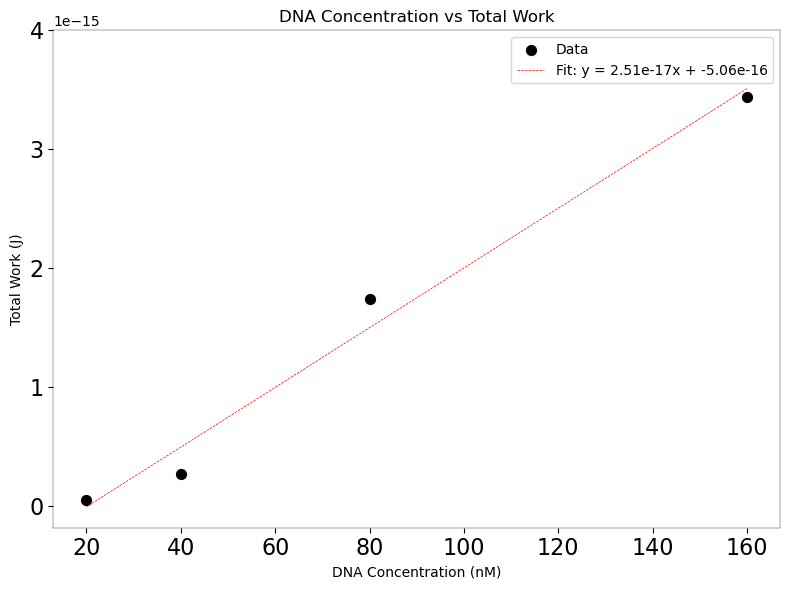

In [10]:
# Create a new figure for DNA concentration vs max work plot
plt.figure(figsize=(8, 6), linewidth=0.5)

# Initialize lists to store DNA concentrations and max work values
dna_concs = []
max_works = []

# Loop through each DNA concentration
for dna_conc in dna_concentrations:
    # Get subset of data for this DNA concentration
    subset = df[df['DNA'] == dna_conc]
    
    # Calculate work if power data exists
    if not subset['power [W]_mean'].isna().all():
        # Get power data and fill NaN values
        power_data = subset['power [W]_mean'].fillna(method='ffill').fillna(method='bfill')
        # Calculate work (integral of power over time)
        time_diff = np.diff(subset['time (s)'])
        work = np.sum(power_data[:-1] * time_diff)
        
        dna_concs.append(dna_conc)
        max_works.append(work)

# Convert to numpy arrays for fitting
dna_concs = np.array(dna_concs)
max_works = np.array(max_works)

# Fit a line to the data
slope, intercept = np.polyfit(dna_concs, max_works, 1)
fit_line = slope * dna_concs + intercept

# Create scatter plot
plt.scatter(dna_concs, max_works, color='black', s=50, label='Data')

# Plot the fitted line
plt.plot(dna_concs, fit_line, 'r--', linewidth=0.5,
         label=f'Fit: y = {slope:.2e}x + {intercept:.2e}')

# Customize plot
plt.xlabel('DNA Concentration (nM)')
plt.ylabel('Total Work (J)')
plt.title('DNA Concentration vs Total Work')
# plt.grid(False, alpha=0.3)
plt.legend()

# Set specific y-axis ticks
plt.yticks([0, 1e-15, 2e-15, 3e-15, 4e-15])

# Reduce frame thickness
plt.gca().spines['top'].set_linewidth(0.25)
plt.gca().spines['right'].set_linewidth(0.25)
plt.gca().spines['bottom'].set_linewidth(0.25)
plt.gca().spines['left'].set_linewidth(0.25)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()

plt.savefig('Fig1_D_JoulesoverDNA.svg', format='svg', dpi=300)

plt.show()


/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_30812/1250582890.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  corr_length = subset['correlation length [m]_mean'].fillna(method='ffill').fillna(method='bfill')


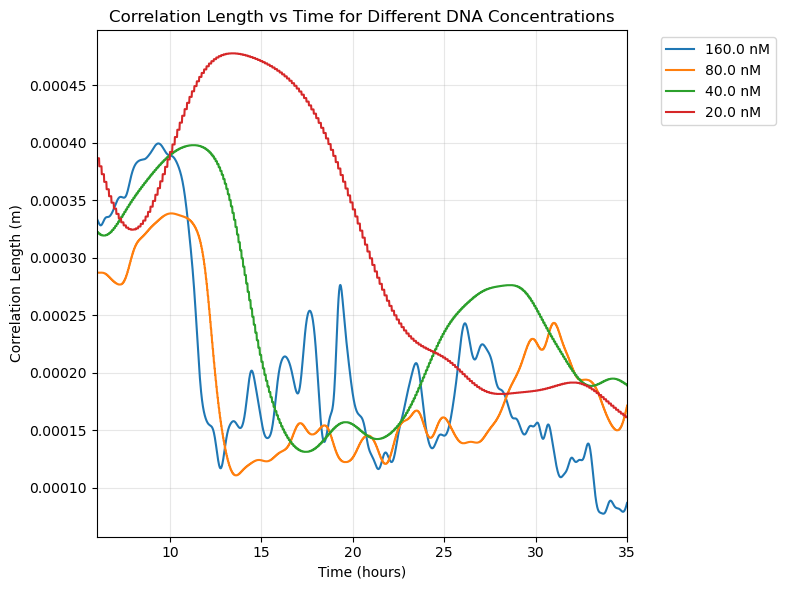

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and dna_concentrations is already defined
# Create a figure
plt.figure(figsize=(8, 6))

# Get the four largest DNA concentrations
largest_dna_concs = sorted(dna_concentrations, reverse=True)[:4]

# Loop through each DNA concentration
for dna_conc in largest_dna_concs:
    # Get subset of data for this DNA concentration
    subset = df[df['DNA'] == dna_conc]
    
    # Plot correlation length vs time if it exists
    if 'correlation length [m]_mean' in subset.columns:
        # Fill NaN values using forward fill then backward fill
        corr_length = subset['correlation length [m]_mean'].fillna(method='ffill').fillna(method='bfill')
        # Convert time from seconds to hours
        time_in_hours = subset['time (s)'] / 3600
        
        # Filter for time between 6h and 35h
        mask = (time_in_hours >= 6) & (time_in_hours <= 35)
        plt.plot(time_in_hours[mask], corr_length[mask], 
                label=f'{dna_conc} nM')

# Customize plot
plt.xlabel('Time (hours)')  # Update label to reflect time in hours
plt.ylabel('Correlation Length (m)')
plt.title('Correlation Length vs Time for Different DNA Concentrations')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(6, 35)  # Set x-axis limits explicitly

plt.tight_layout()
plt.show()

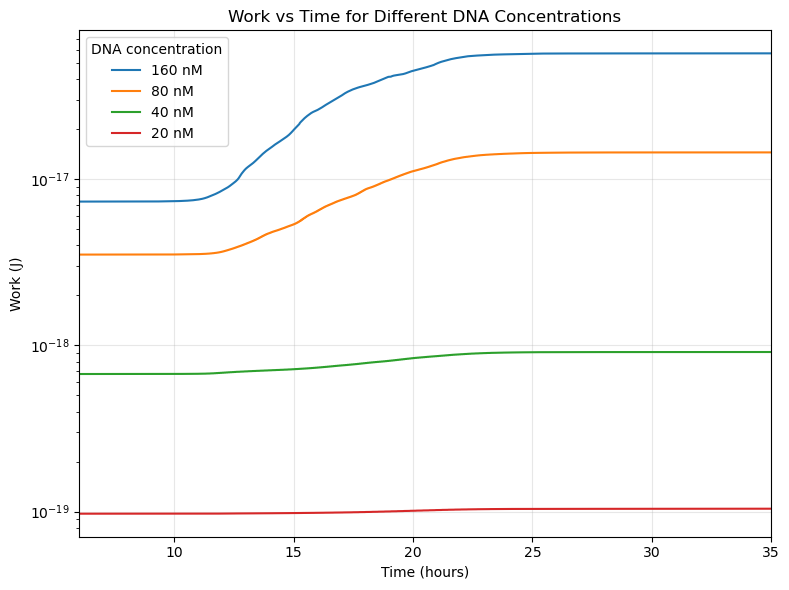

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a figure
plt.figure(figsize=(8, 6))

# Get the four largest DNA concentrations
largest_dna_concs = sorted(dna_concentrations, reverse=True)[:4]

# Loop through each DNA concentration
for dna_conc in largest_dna_concs:
    # Get subset of data for this DNA concentration
    subset = df[df['DNA'] == dna_conc]
    
    # Plot work vs time if it exists
    if 'work [J]_mean' in subset.columns:
        # Fill NaN values using forward fill then backward fill
        work_data = subset['work [J]_mean'].ffill().bfill()
        # Convert time from seconds to hours
        time_in_hours = subset['time (s)'] / 3600
        
        # Filter for time between 6h and 35h
        mask = (time_in_hours >= 6) & (time_in_hours <= 35)
        plt.plot(time_in_hours[mask], work_data[mask], 
                label=f'{int(dna_conc)} nM')

# Customize plot
plt.xlabel('Time (hours)')
plt.ylabel('Work (J)')
plt.title('Work vs Time for Different DNA Concentrations')
plt.grid(True, alpha=0.3)
plt.legend(title='DNA concentration', loc='upper left')
plt.xlim(6, 35)

# set y axis to log scale
plt.yscale('log')

plt.tight_layout()
plt.show()


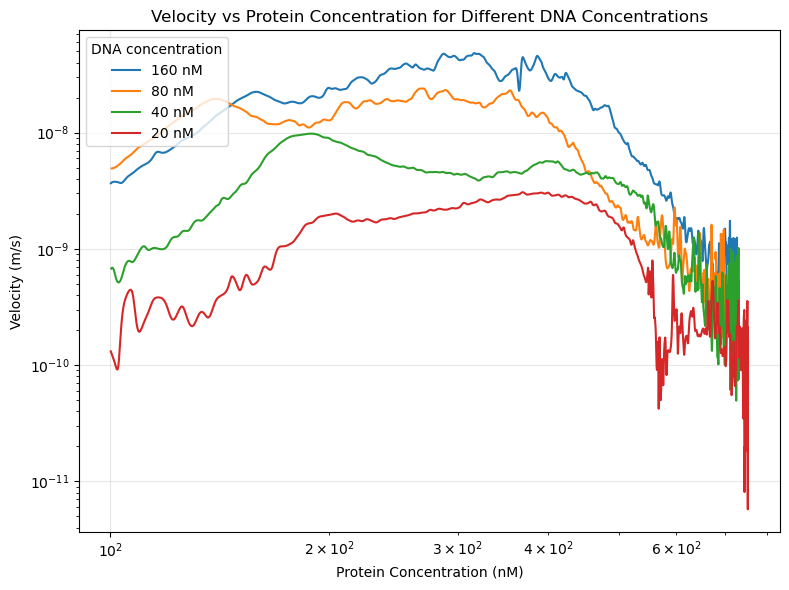

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Create a figure
plt.figure(figsize=(8, 6))

# Get the four largest DNA concentrations
largest_dna_concs = sorted(dna_concentrations, reverse=True)[:4]

# Loop through each DNA concentration
for dna_conc in largest_dna_concs:
    # Get subset of data for this DNA concentration
    subset = df[df['DNA'] == dna_conc]
    
    # Get velocity and protein concentration data
    velocity_data = subset['velocity magnitude [m/s]_mean'].ffill().bfill()
    protein_conc = subset['Protein Concentration_nM'].ffill().bfill()
    
    # Apply Gaussian filter
    velocity_smooth = gaussian_filter1d(velocity_data, sigma=3)
    protein_smooth = gaussian_filter1d(protein_conc, sigma=3)
    
    # Filter for protein concentration >= 100 nM
    mask = protein_smooth >= 100
    
    # Plot velocity vs protein concentration
    plt.plot(protein_smooth[mask], velocity_smooth[mask],
            label=f'{int(dna_conc) if dna_conc.is_integer() else dna_conc} nM')

# Customize plot
plt.xlabel('Protein Concentration (nM)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Protein Concentration for Different DNA Concentrations')
plt.grid(True, alpha=0.3)
plt.legend(title='DNA concentration', loc='upper left')

# Set scales to log
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()
